# MTpy Example 11

## Modeling

Looking at the MT response is useful for understanding your data and generally what the data represents.  However, to get a full understanding of the subsurface we need to convert the measured MT response to an Earth response through forward modeling and inversion.  1D and 2D modeling can be done using Simpeg.  Here we will look at creating input files for ModEM.  We will create a model area with the option of adding topography.


In [1]:
from pathlib import Path
import numpy as np
from mtpy import MTCollection
from mtpy.modeling import StructuredGrid3D
from mtpy.modeling.modem import Covariance, ControlInv, ControlFwd

%matplotlib widget

### Open MTCollection

Open the MTH5 and export to `MTData` object. Be sure to set the UTM CRS so we can compute relative distances.

In [2]:
%%time
with MTCollection() as mc:
    mc.open_collection(Path(r"../../../scratch/nm05/jp0633/musgraves_edis/musgraves_tf.h5"))
    # apply bounding box here
    # mc.apply_bbox(129, 133, -28.2, -25.8)
    mt_data = mc.to_mt_data()
    mt_data.utm_crs = 28353

23:11:16T07:27:32 | INFO | line:760 |mth5.mth5 | close_mth5 | Flushing and closing ../../../scratch/nm05/jp0633/musgraves_edis/musgraves_tf.h5
CPU times: user 8.23 s, sys: 201 ms, total: 8.43 s
Wall time: 9.17 s


## Plot Stations

Lets plot the station coverage and see if we want to remove any stations or set a bounding box. Its usually advantageous to have a relatively uniform station coverage so that the mesh doesn't get excessively large when there are a few outlying stations.  

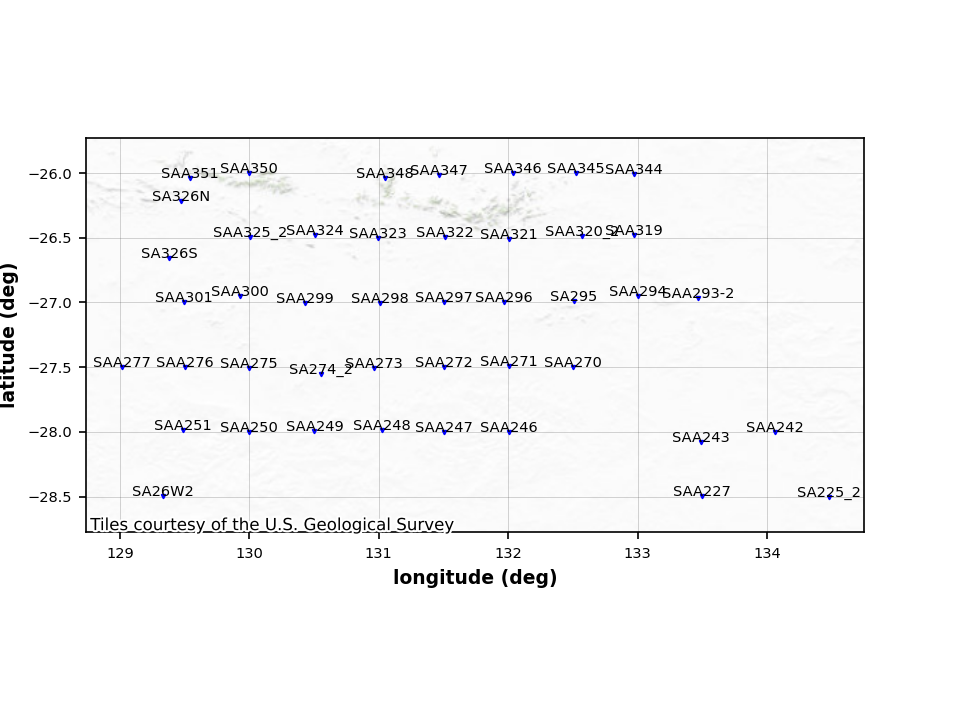

In [3]:
plot_stations = mt_data.plot_stations(fig_num=1)

### Remove stations

For example sake lets remove a few stations, namely the outliers `SA225_2`, `SAA242`, `SA277`.  

<div class="alert alert-block alert-info">
<b>Tip:</b> You could also apply a bounding box and get a similar result.
</div>

In [4]:
for station_id in ["SA225_2", "SAA242", "SA277"]:
    mt_data.remove_station(station_id, "Musgraves_SA")

### Replot Stations

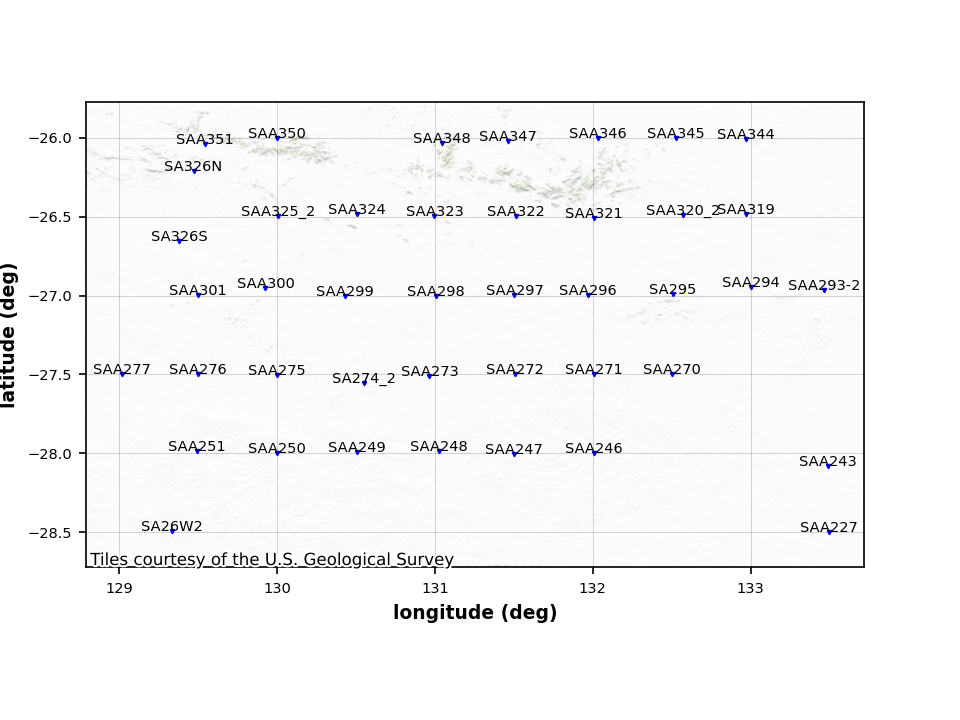

In [5]:
plot_stations_02 = mt_data.plot_stations(fig_num=5)

## Model Periods

Now that we have a decent station coverage we need to choose the periods to invert.  For 3D this is commonly decided by the computer architecture because the parallelization is often by period.  Our compute power is only limited to the number of processors you want to use, and it usually depends on the HPC architecture as the optimum number of processors to use per node. Depends on the node you use, so do a little research on optimum nodes or ask Nigel. 

<div class="alert alert-block alert-info">
<b>Tip:</b> ModEM uses one node as a controller, so be sure to take that into account when choosing the number of periods and nodes to use.  So if you use a node with 24 processors invert for 23 periods.
</div>

Here we are going to create evenly spaced periods along a logarithmic scale and interpolate all the stations onto those periods.  This data set is relatively homogenous because it was processed with the same parameter, but when you start mixing surveys and data from other sources the periods estimated in the transfer function can differ.  The interpolation is a 1D interpolation for the real and imaginary parts of the transfer functions.  You can change the interpolation method if you want.  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html for options.  

In [6]:
interp_periods = np.logspace(1, 4, 23)

In [7]:
interp_periods

array([   10.        ,    13.6887451 ,    18.73817423,    25.65020906,
          35.11191734,    48.06380863,    65.79332247,    90.06280202,
         123.28467394,   168.76124758,   231.01297001,   316.22776602,
         432.87612811,   592.55309755,   811.13083079,  1110.33631817,
        1519.91108295,  2080.56753822,  2848.03586844,  3898.60370255,
        5336.69923121,  7305.27154266, 10000.        ])

In [8]:
%%time
interp_mt_data = mt_data.interpolate(interp_periods, inplace=False)

CPU times: user 43.9 s, sys: 924 ms, total: 44.8 s
Wall time: 44.8 s


Just check to make sure interpolation is accurate, lets plot some stations together.

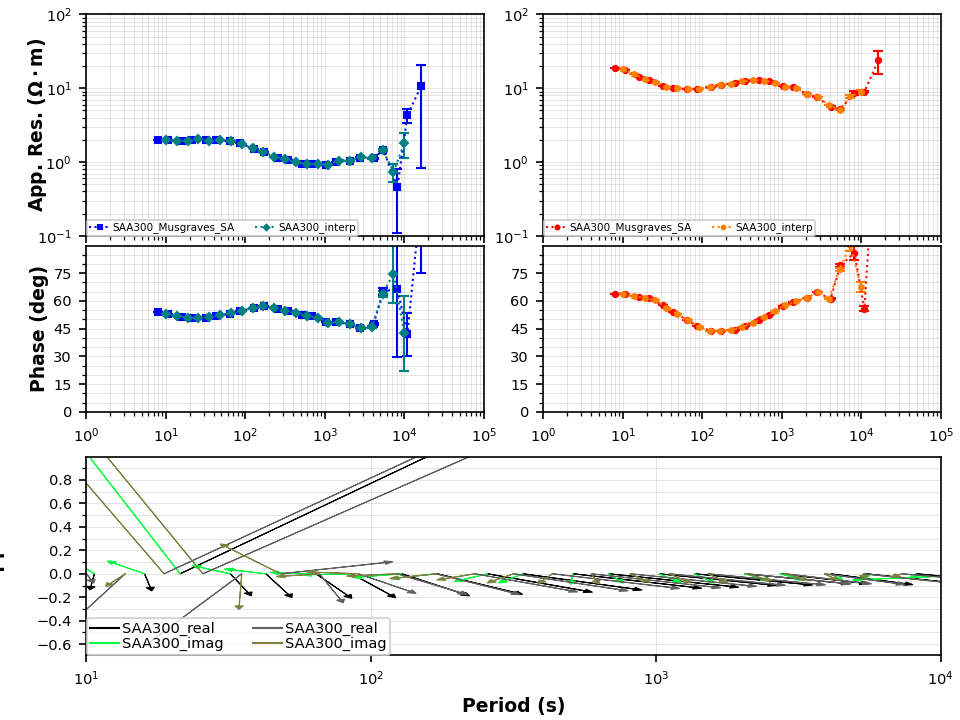

In [9]:
mt_01 = mt_data.get_subset(["Musgraves_SA.SAA300"])
mt_02 = interp_mt_data.get_station(station_key="Musgraves_SA.SAA300").copy()
mt_02.survey = "interp"
mt_01.add_station(mt_02)

pmr = mt_01.plot_mt_response(station_key=list(mt_01.keys()), plot_style="compare", fig_num=9, plot_tipper="yri")

## Model Errors

Now that we have a decent station coverage and all data on the same period map we need to assigne model errors.  Typically we use some combination of the diagonal components and set an error floor of between 3 - 5%.  Below are the supported error types.

| Error Type          |    Dfinition                         |
|------------------------|---------------------------------------|
| egbert                |     error_value * sqrt(Zxy * Zyx) |
| geometric_mean        |    error_value * sqrt(Zxy * Zyx) |
| arithmetic_mean       |   error_value * (Zxy + Zyx) / 2 |
| mean_od               |     error_value * (Zxy + Zyx) / 2 |
| off_diagonals         |     zxx_err == zxy_err, zyx_err == zyy_err |
| median                |     error_value * median(z) |
| eigen                 |     error_value * mean(eigen(z)) |
| percent               |     error_value * z |
| absolute              |     error_value |

For this excersize we will use the defaults which are:

  - Impedance
     - `error_type = 'geometric_mean'`
     - `error_value = 0.05`
     - `floor = True`
  - Tipper
     - `error_type = 'absolute'`
     - `error_value = 0.02`
     - `floor = True`
     

In [10]:
interp_mt_data.compute_model_errors()

## Model Locations

ModEM Uses a relative grid for calculating the fields and is agnostic to geospatial postion.  Therefore, we need to place our stations on a relative grid where the center point is (0, 0).  We can then use these locations to make a model mesh. Somewhat counterintuitvely we need to provide a UTM coordinate system to estimate the easting and northing.  We will use EPSG=7842

In [11]:
interp_mt_data.utm_epsg = 28353

In [12]:
interp_mt_data.compute_relative_locations()

In [13]:
interp_mt_data.station_locations

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,model_north,model_elevation,profile_offset
0,Musgraves_SA,SA26W2,-28.49435,129.33328,335.0,4326,-55099.872154,6.834909e+06,28353,-185549.819238,-143457.122523,335.0,0.0
1,Musgraves_SA,SA274_2,-27.55531,130.55070,504.0,4326,60495.469508,6.944150e+06,28353,-69954.477577,-34215.661515,504.0,0.0
2,Musgraves_SA,SA295,-26.99104,132.50675,564.0,4326,252565.082031,7.012111e+06,28353,122115.134947,33745.146796,564.0,0.0
3,Musgraves_SA,SA326N,-26.21286,129.46975,646.0,4326,-52980.732057,7.088929e+06,28353,-183430.679141,110563.154046,646.0,0.0
4,Musgraves_SA,SA326S,-26.65605,129.37950,544.0,4326,-59866.266608,7.039312e+06,28353,-190316.213692,60946.114273,544.0,0.0
5,Musgraves_SA,SAA227,-28.49864,133.49527,211.0,4326,352727.530614,6.846634e+06,28353,222277.583529,-131731.894653,211.0,0.0
6,Musgraves_SA,SAA243,-28.07727,133.49181,256.0,4326,351805.849365,6.893318e+06,28353,221355.902281,-85048.075568,256.0,0.0
7,Musgraves_SA,SAA246,-27.99918,132.00528,407.0,4326,205473.029042,6.899271e+06,28353,75023.081957,-79094.797151,407.0,0.0
8,Musgraves_SA,SAA247,-28.00371,131.50056,368.0,4326,155816.650905,6.897446e+06,28353,25366.703820,-80920.072211,368.0,0.0
9,Musgraves_SA,SAA248,-27.98589,131.02246,375.0,4326,108689.302894,6.897979e+06,28353,-21760.644191,-80387.293872,375.0,0.0


In [14]:
interp_mt_data.center_point

MT Location: 
--------------------
  Latitude (deg):   -27.267944
  Longitude (deg):  131.267928
  Elevation (m):    0.0000
  Datum crs:        EPSG:4326

  Easting (m):      130449.947
  Northing (m):     6978366.111
  UTM crs:          EPSG:28353

  Model Easting (m):      130449.947
  Model Northing (m):     6978366.111
  Model Elevation (m):    0.000
  Profile Offset (m):     0.000

<AxesSubplot: xlabel='model_east', ylabel='model_north'>

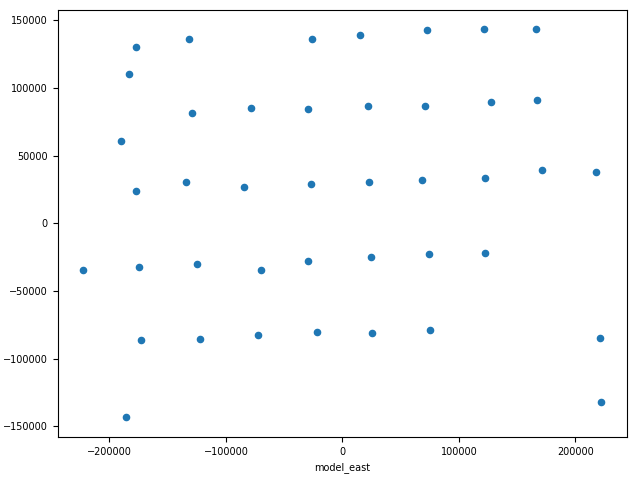

In [15]:
interp_mt_data.station_locations.plot.scatter(x="model_east", y="model_north")

## Write Data File

The data now latitudeel errors, model locations, and a common period map.  Now we can write to a file.

In [16]:
modem_data = interp_mt_data.to_modem_data(
    Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_z05_t02.dat"),
    topography=False
)

23:11:16T07:28:45 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in zxy 84 times. Setting error as zxy x 0.05.
23:11:16T07:28:45 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in zyx 13 times. Setting error as zyx x 0.05.
23:11:16T07:28:45 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in zyy 10 times. Setting error as zyy x 0.05.
23:11:16T07:28:45 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in tzx 1 times. Setting error as tzx x 0.02.
23:11:16T07:28:45 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in tzy 2 times. Setting error as tzy x 0.02.
23:11:16T07:28:45 | INFO | line:809 |mtpy.modeling.modem.data | write_data_file | Wrote

In [17]:
modem_data

ModEM Data Object:
	Number of impedance stations: 42
	Number of tipper stations: 42
	Number of phase tensor stations: 0
	Number of periods:  23
	Period range (s):  
		Min: 10
		Max: 10000
	Rotation angle:     0
	Data center:        
		Latitude:  -27.2679 deg 	Northing: 6978366.1107 m
		Longitude: 131.2679 deg 	Easting: 130449.9471 m
		Datum epsg: 4326			UTM epsg:   28353
		Elevation:  0.0 m
	Impedance data:     True
	Tipper data:        True
	Inversion Mode:   Full_Impedance, Full_Vertical_Components

## Model Grid

ModEM uses the finite difference which computes the fields on the faces of an unstructured rectangular grid.  

### Horizontal Cells

In the horizontal direction cell sizes are often uniform in width within the area of interest.  Commonly you would like at least 1 free cell between stations and usually more to allow the inversion to model smoothly varying resistivity structures.  So if your station spaceing is 2 km, your model cell sizes could be between 200 - 1000 meters.  

### Vertical Cells
In the vertical direction the height should increase with depth to account for MT being a diffusive method.  The rate of increase would ideally be a geometric factor of about 1.2, but computationally this can be expensive, therefore it is a good idea to change that parameter to grid that can provide resolution down to a desired depth and be relatively efficient.  The first layer should be about 1/5th the skin depth of your shortest period.  If you shortest period is 0.01 seconds and an estimate of the subsurface apparent resistivity is 100, then your skin depth is 500 * sqrt(0.01 * 100) = 500 m, and your top layer could be 100 m.  

### Padding Cells
Because MT is a volumetric measurement and measurement periods are long, the model needs to be sufficiently large enough to minimize edge effects.  The extents of the model should be about 2-5 times the maximum skin depth away from the station area.  If your longest period is 1000 seconds, the approximate skin depth for an apparent resistivity of 100 would be 500 * sqrt(1000 * 100) ~ 150 km.  Therefore your model should extend at leat 150 km from the edge of the station area in all directions.  So if you station area is 25 km v 25 km your model extents should be 325 km x 325 km.  Now this isn't always practical and the skin depths are just estimates, so playing around with padding cells can be a useful excersize.  These padding cells can be large and you may only need a few.

### Making the Mesh
To make the mesh we need the station locations and the center point. We will set some parameters that are coarse so that this can run on a desktop.

In [18]:
model_mesh = StructuredGrid3D()

In [19]:
model_mesh.station_locations = interp_mt_data.station_locations.copy()

In [20]:
model_mesh.center_point = interp_mt_data.center_point.copy()

<AxesSubplot: xlabel='model_east', ylabel='model_north'>

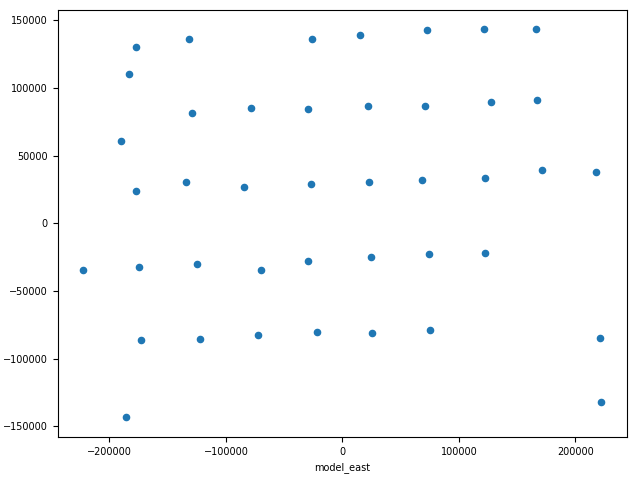

In [21]:
model_mesh.station_locations.plot.scatter(x="model_east", y="model_north")

Structured3DMesh Model Object:
--------------------
	Number of stations = 42
	Mesh Parameter: 
		cell_size_east:    12000
		cell_size_north:   12000
		pad_east:          7
		pad_north:         7
		pad_num:           6
		z1_layer:          50
		z_target_depth:    200000
		n_layers:          40
		n_air_layers:      0
		res_initial_value: 100.0
	Dimensions: 
		e-w: 72
		n-s: 56
		z:   41 (without 7 air layers)
	Extensions: 
		e-w:  3024000.0 (m)
		n-s:  2992000.0 (m)
		0-z:  419123.0 (m)
--------------------
23:11:16T07:28:46 | WARNING | line:51 |mtpy.modeling.plots.plot_mesh | _plot_topography | Cannot find topography information, skipping
23:11:16T07:28:46 | WARNING | line:99 |mtpy.modeling.plots.plot_mesh | _plot_topography_ax2 | Cannot find topography information, skipping


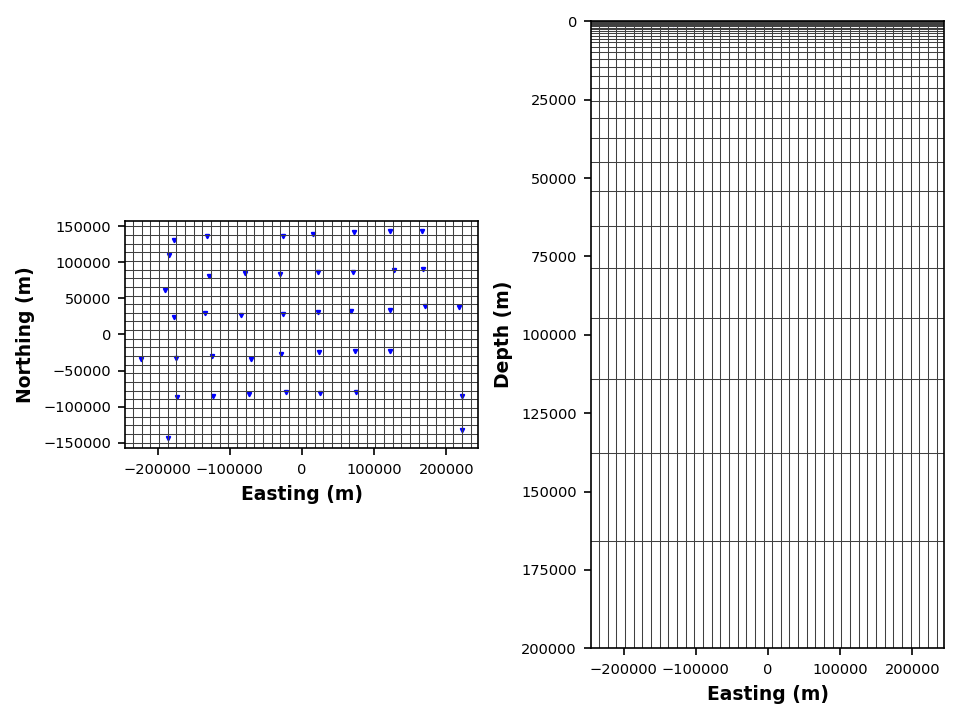

Plotting PlotMesh

In [22]:
model_mesh.cell_size_east = 12000
model_mesh.cell_size_north = 12000
model_mesh.z1_layer = 50
model_mesh.z_target_depth = 200000
model_mesh.n_layers = 40
model_mesh.pad_num = 6
model_mesh.ew_ext = 3000000
model_mesh.ns_ext = 3000000
model_mesh.make_mesh()
model_mesh.plot_mesh(fig_num=8, plot_station_id=False)

## Estimating Starting Half Space

The starting half-space is important because it provides the inversion with a decent starting point. Therefore, in practice it is a good idea to estimate what a good starting resistivity is.  Here we will take the average and median of all apparent resistivity values across the survey.  From this 100 is a good choice, which is a common starting resistivity.

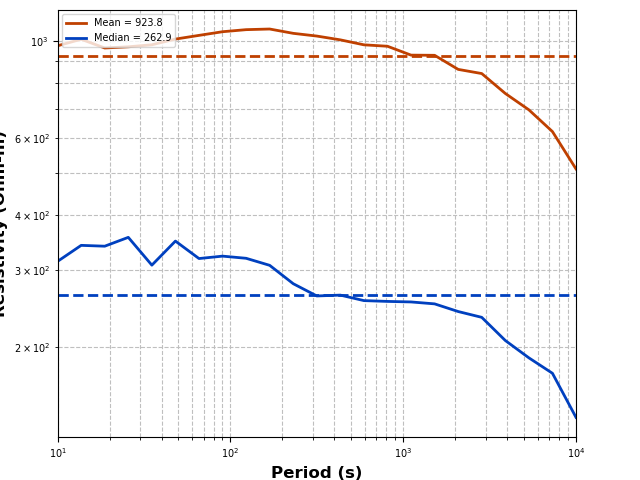

In [23]:
interp_mt_data.estimate_starting_rho()

## Write Model File

We have a decent mesh, lets write to a file

In [24]:
model_mesh.to_modem(
    **{"model_fn": Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_sm500.rho"), 
       "res_initial_value":500},
)

23:11:16T07:28:48 | INFO | line:872 |mtpy.modeling.structured_mesh_3d | to_modem | Wrote file to: /home/005/jp0633/mt_examples/data/modeling/musgraves_sm500.rho


## Covariance 

ModEM uses a regularization parameter called covariance, which controls how smooth the inversion should be, with higher values being more smooth and lower values being coarser.  You can apply the covariance multiple times if you like, so sometimes it is adventageous to use a smaller covariance value but apply it multiple times.  The covariance in ModEM sort of describes the length of smoothing, in that it uses the a certain number of cells depending on the value.  At the padding cells this can blowup and provide unrealistic values and are usually ignored in plotting.  Varying the covariance is an excersize in itself.  For this we will apply a common covariance of 0.3 in all directions just once.

In [25]:
covariance = Covariance(grid_dimensions=model_mesh.res_model.shape)
covariance.write_covariance_file(
    Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves.cov")
)

23:11:16T07:28:48 | INFO | line:209 |mtpy.modeling.modem.convariance | write_covariance_file | Wrote covariance file to /home/005/jp0633/mt_examples/data/modeling/musgraves.cov


## Control Files

How ModEM computes the forward model and how the inversion runs can be controlled through control files.  These are often kept to the default values, you may change the starting lambda depending on your modeling method.

In [26]:
control_fwd = ControlFwd()
control_fwd.write_control_file(
    Path().cwd().joinpath("mt_examples", "data", "modeling", "control.fwd")
)

Wrote ModEM control file to /home/005/jp0633/mt_examples/data/modeling/control.fwd


In [27]:
control_inv = ControlInv()
control_inv.write_control_file(
    Path().cwd().joinpath("mt_examples", "data", "modeling", "control.inv")
)

Wrote ModEM control file to /home/005/jp0633/mt_examples/data/modeling/control.inv


### Adding Topography

For topographically extreme areas it can be useful to include topography into the model.  We just need to provide an ascii elevation file formatted in the form ArcGIS.  More formats will be supported in the future, but these are relatively common for coarse topography.  You can download DEMs from [https://www.ncei.noaa.gov/maps/grid-extract/](https://www.ncei.noaa.gov/maps/grid-extract/).  One is provided for this data set.  

**Note**: If you are including topography in the model, you need to center the stations to the model cell, otherwise weird things can happen.  

##### Add Topography from Data

If you don't have a DEM and want to do a quick and easy elevation estimation you can estimate from the data.  This probably shouldn't be used in practice unless you have a dense station coverage.

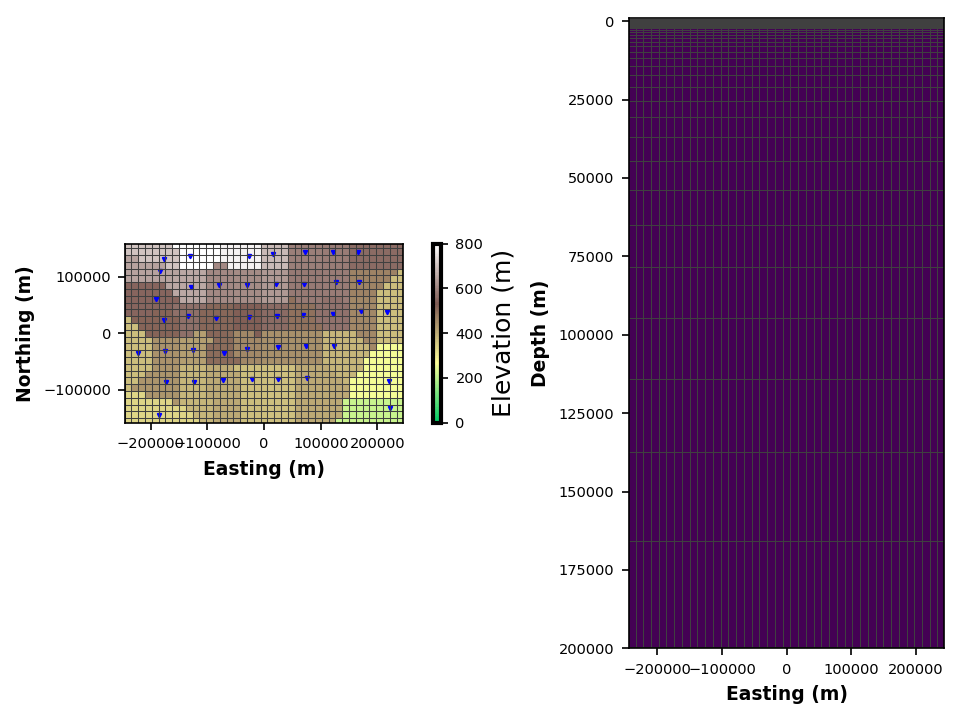

Plotting PlotMesh

In [28]:
model_mesh.n_air_layers = 15
model_mesh.add_topography_from_data()
model_mesh.plot_mesh(fig_num=13)

##### Add from DEM file

For now the preferred format for a DEM is an ASCII file formatted as:

```
ncols        2743
    nrows        2019
    xllcorner    111.791666666667 (lon of lower left)
    yllcorner    -45.341666666667 (lat of lower left)
    cellsize     0.016666666667
    NODATA_value  -9999
    elevation data origin (0,0) is NW upper left.
    NW --------------> E
    |
    |
    |
    |
    S
```

<div class="alert alert-block alert-info">
    <b> Info: </b> In the future a geoTiff will be accepted as well and that will be the preferred format for a DEM.
</div>

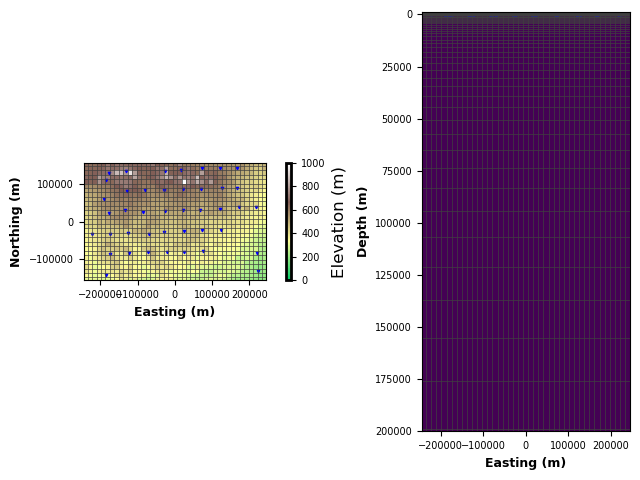

23:11:16T07:28:50 | INFO | line:872 |mtpy.modeling.structured_mesh_3d | to_modem | Wrote file to: /home/005/jp0633/mt_examples/data/modeling/musgraves_sm500_topo.rho


In [29]:
model_mesh.n_air_layers = 15
model_mesh.add_topography_to_model(
    Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_dem_b.asc"),
    airlayer_type="log_down"
)
model_mesh.plot_mesh(fig_num=10)
model_mesh.to_modem(
    **{"model_fn": Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_sm500_topo.rho"), 
       "res_initial_value":500},
)

### Write Topography Covariance

Now that topography is added into the model we want to make sure the air cells remain locked.

In [30]:
topo_covariance = Covariance(grid_dimensions=model_mesh.res_model.shape)
topo_covariance.write_covariance_file(
    Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_covariance_topo.cov"),
    model_fn=model_mesh.model_fn,
)

IndexError: invalid index to scalar variable.

## Centering Station and Projecting on to Topography

We need to now center the stations to their cell and project the station to the topgraphic surface.

In [31]:
interp_mt_data.center_stations(model_mesh)
interp_mt_data.project_stations_on_topography(model_mesh)
interp_mt_data.station_locations

,survey,station,latitude,longitude,elevation,datum_epsg,east,north,utm_epsg,model_east,model_north,model_elevation,profile_offset
0,Musgraves_SA,SA26W2,-28.49435,129.33328,335.0,4326,-55099.872154,6.834909e+06,28353,-180000.0,-144000.0,-375.999,0.0
1,Musgraves_SA,SA274_2,-27.55531,130.55070,504.0,4326,60495.469508,6.944150e+06,28353,-72000.0,-36000.0,-493.999,0.0
2,Musgraves_SA,SA295,-26.99104,132.50675,564.0,4326,252565.082031,7.012111e+06,28353,120000.0,36000.0,-597.999,0.0
3,Musgraves_SA,SA326N,-26.21286,129.46975,646.0,4326,-52980.732057,7.088929e+06,28353,-180000.0,108000.0,-597.999,0.0
4,Musgraves_SA,SA326S,-26.65605,129.37950,544.0,4326,-59866.266608,7.039312e+06,28353,-192000.0,60000.0,-493.999,0.0
5,Musgraves_SA,SAA227,-28.49864,133.49527,211.0,4326,352727.530614,6.846634e+06,28353,228000.0,-132000.0,-242.999,0.0
6,Musgraves_SA,SAA243,-28.07727,133.49181,256.0,4326,351805.849365,6.893318e+06,28353,216000.0,-84000.0,-242.999,0.0
7,Musgraves_SA,SAA246,-27.99918,132.00528,407.0,4326,205473.029042,6.899271e+06,28353,72000.0,-84000.0,-375.999,0.0
8,Musgraves_SA,SAA247,-28.00371,131.50056,368.0,4326,155816.650905,6.897446e+06,28353,24000.0,-84000.0,-375.999,0.0
9,Musgraves_SA,SAA248,-27.98589,131.02246,375.0,4326,108689.302894,6.897979e+06,28353,-24000.0,-84000.0,-375.999,0.0


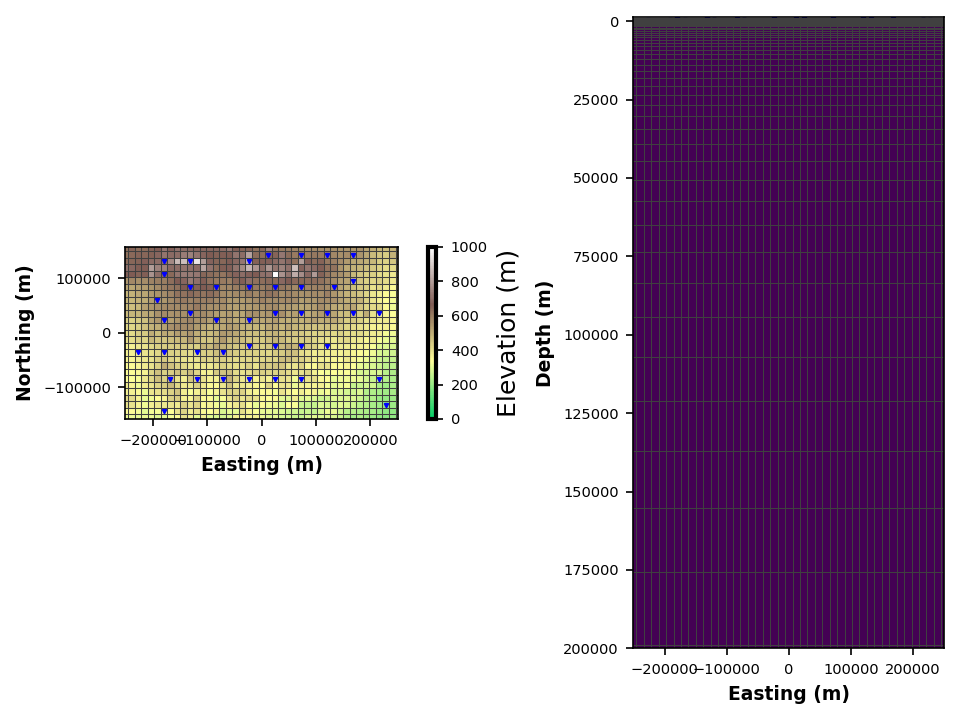

Plotting PlotMesh

In [32]:
model_mesh.station_locations = interp_mt_data.station_locations
model_mesh.plot_mesh(fig_num=15)

In [33]:
interp_mt_data.to_modem_data(
    Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_z05_t02_topo.dat"),
    topography=True
)

23:11:16T07:30:20 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in zxy 84 times. Setting error as zxy x 0.05.
23:11:16T07:30:20 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in zyx 13 times. Setting error as zyx x 0.05.
23:11:16T07:30:20 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in zyy 10 times. Setting error as zyy x 0.05.
23:11:16T07:30:20 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in tzx 1 times. Setting error as tzx x 0.02.
23:11:16T07:30:20 | WARNING | line:711 |mtpy.modeling.modem.data | _check_for_too_small_errors | Found errors with values less than 0.02 in tzy 2 times. Setting error as tzy x 0.02.
23:11:16T07:30:20 | INFO | line:809 |mtpy.modeling.modem.data | write_data_file | Wrote

ModEM Data Object:
	Number of impedance stations: 42
	Number of tipper stations: 42
	Number of phase tensor stations: 0
	Number of periods:  23
	Period range (s):  
		Min: 10
		Max: 10000
	Rotation angle:     0
	Data center:        
		Latitude:  -27.2679 deg 	Northing: 6978366.1107 m
		Longitude: 131.2679 deg 	Easting: 130449.9471 m
		Datum epsg: 4326			UTM epsg:   28353
		Elevation:  0.0 m
	Impedance data:     True
	Tipper data:        True
	Inversion Mode:   Full_Impedance, Full_Vertical_Components

 ## Write PBS directives
 
 Now we would like to setup a shell script with PBS directives to run ModEM.
 
 It should looks something like:

```
#!/bin/bash
#PBS -N run_name
#PBS -q normal
#PBS -P tq84
#PBS -l walltime=0:20:00
#PBS -l ncpus=48
#PBS -l mem=190GB
#PBS -l jobfs=10GB
#PBS -l storage=gdata/nm05+scratch/nm05
 
module load ModEM-geophysics/2015.01
 
cd /scratch/nm05/nre900/ModEM_example
 
mpirun -np 48 Mod3DMT_MPI -I NLCG model_file.rho data_file.dat control.inv control.fwd covariance.cov > output_file.out
```

In [37]:
lines = ["#!/bin/bash"]
lines.append("#PBS -N run_name")
lines.append("#PBS -q normal")
lines.append("#PBS -P tq84")
lines.append("#PBS -l walltime=1:00:00")
lines.append("#PBS -l ncpus=48")
lines.append("#PBS -l mem=190GB")
lines.append("#PBS -l jobfs=10GB")
lines.append("#PBS -l storage=gdata/nm05+scratch/nm05")
lines.append("")
lines.append("module load ModEM-geophysics/2015.01")
lines.append("")
lines.append("cd /mt_examples/data/modeling")
lines.append("mpirun -np 48 Mod3DMT_MPI -I NLCG musgraves_sm500.rho musgraves_z05_t02.dat control.inv control.fwd musgraves.cov > musgraves_flat.out")
 
with open(Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_modem_flat.sh"), "w") as fid:
    fid.write("\n".join(lines))
    

Invert with topography

In [38]:
lines = ["#!/bin/bash"]
lines.append("#PBS -N run_name")
lines.append("#PBS -q normal")
lines.append("#PBS -P tq84")
lines.append("#PBS -l walltime=1:00:00")
lines.append("#PBS -l ncpus=48")
lines.append("#PBS -l mem=190GB")
lines.append("#PBS -l jobfs=10GB")
lines.append("#PBS -l storage=gdata/nm05+scratch/nm05")
lines.append("")
lines.append("module load ModEM-geophysics/2015.01")
lines.append("")
lines.append("cd /mt_examples/data/modeling")
lines.append("mpirun -np 48 Mod3DMT_MPI -I NLCG musgraves_sm500_topo.rho musgraves_z05_t02_topo.dat control.inv control.fwd musgraves_topo.cov > musgraves_topo.out")
 
with open(Path().cwd().joinpath("mt_examples", "data", "modeling", "musgraves_modem_topo.sh"), "w") as fid:
    fid.write("\n".join(lines))